In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import time
from datetime import date
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# import optuna
import catboost as cat
from catboost import Pool


os.chdir("c:/jiaqifiles/Rdata/")
VIXRB1 = pd.read_csv("VIXfutsallinfo111.csv")
VIXRB1.rename(columns={'X':'VX1','X.1':'VX2','dt1':'d2','dr1':'d1'}, inplace=True)
# VIXRB1.drop(['index'],inplace=True)

lookahead = 1
VIXRB1['Date'] = pd.to_datetime(VIXRB1['Date'])

VIXRB1['y'] = -1*(VIXRB1['SPVXSP'].shift(-1)/VIXRB1['SPVXSP']-1)/1 # y is the XIV return 
VIXRB1['classy'] = -1*(VIXRB1['SPVXSP'].shift(-lookahead)/VIXRB1['SPVXSP']-1)/lookahead # y is the XIV return 
# VIXRB1['y'] = 1*(VIXRB1['SPY'].shift(-lookahead)/VIXRB1['SPY']-1)/lookahead # y is the XIV return 
VIXRB1['mu'] = VIXRB1['mat20']/VIXRB1['VIX']-1
VIXRB1['prem'] = VIXRB1['mat20']/VIXRB1['VIX3M']
VIXRB1['vratio'] = VIXRB1['VIX']/VIXRB1['VIX3M']
VIXRB1['SPYret'] = 1*(VIXRB1['SPY']/VIXRB1['SPY'].shift(1)-1)
VIXRB1['VIXret'] = 1*(VIXRB1['VIX']/VIXRB1['VIX'].shift(1)-1)
VIXRB1['XIVret'] = -1*(VIXRB1['SPVXSP']/VIXRB1['SPVXSP'].shift(1)-1)
# colnames(VIXRB1)[2:5]=c("VX1","VX2","d2","d1")
print(VIXRB1.columns)
# print(VIXRB1.head())

# I want to drop the columns from d2 to w12 by names
VIXRB1.drop(VIXRB1.columns[3:6], axis=1, inplace=True)
VIXRB1.tail()

Index(['Date', 'VX1', 'VX2', 'd2', 'd1', 'w11', 'w12', 'mat20', 'VIX',
       'SPVXSP', 'SPX', 'macd', 'signal', 'IEF', 'QQQ', 'SPY', 'VIX3M',
       'SPVXMP', 'y', 'classy', 'mu', 'prem', 'vratio', 'SPYret', 'VIXret',
       'XIVret'],
      dtype='object')


,Date,VX1,VX2,w12,mat20,VIX,SPVXSP,SPX,macd,signal,...,VIX3M,SPVXMP,y,classy,mu,prem,vratio,SPYret,VIXret,XIVret
4838,2025-03-17,20.8352,19.9169,0.947368,19.966285,20.51,10238.2600,5675.12,8.146613,9.324706,...,21.30,6512.50,-0.028303,-0.028303,-0.026510,0.937384,0.962911,0.007711,-0.057878,0.036643
4839,2025-03-18,21.6300,20.4806,1.000000,20.480600,21.70,10528.0300,5614.66,7.147765,8.889318,...,21.97,6563.71,0.035221,0.035221,-0.056194,0.932208,0.987711,-0.010808,0.058020,-0.028303
4840,2025-03-19,19.7513,20.4806,0.047619,19.786638,19.90,10157.2200,5675.29,5.639827,8.239420,...,20.83,6460.92,0.017402,0.017402,-0.005697,0.949911,0.955353,0.010891,-0.082949,0.035221
4841,2025-03-20,19.4005,20.4806,0.095238,19.505944,19.80,9980.4649,5662.89,4.351276,7.461791,...,20.71,6413.79,-0.000793,-0.000793,-0.014851,0.941861,0.956060,-0.002892,-0.005025,0.017402
4842,2025-03-21,19.4179,20.4806,0.142857,19.573247,19.28,9988.3760,5667.56,3.092697,6.587972,...,20.35,6382.52,NaN,NaN,0.015210,0.961830,0.947420,0.000329,-0.026263,-0.000793


In [2]:
# I want to create new columns which is the rolling z score of VIX and mat20 columns respectively
# VIXRB1['VIXz'] = (VIXRB1['VIX']-VIXRB1['VIX'].rolling(20).mean())/VIXRB1['VIX'].rolling(20).std()
# VIXRB1['mat20z'] = (VIXRB1['mat20']-VIXRB1['mat20'].rolling(20).mean())/VIXRB1['mat20'].rolling(20).std()

# I want to sepcify multiple rolling windows and the columns I want to calculate the zscore and then merge them together automatically
# I want to create a function to do this
def rollz(df,rollwindow,colname):
    df[colname+str(rollwindow)+'z'] = (df[colname]-df[colname].rolling(rollwindow).mean())/df[colname].rolling(rollwindow).std()
    return df

# I want to use the above function to create the rolling z score of VIx, mat20, VX1 for window of 20, 60 and 250 in a nested for loop
vars = ['VIX','mat20','VX1']
vars = ['VIX','mu','prem','vratio']
windows = [5,10,20,60,252]
windows = [5,20,60,252]
for i in windows:
    for j in vars:
        VIXRB1 = rollz(VIXRB1,i,j)

# estimate the rolling skewness and kurtosis of XIVret, SPYret and VIXret for window of 20, 60 and 250 in a nested for loop
vars = ['SPYret','VIXret','XIVret','mu']
vars = ['VIX','VIXret','XIVret','mu','prem','vratio']
windows = [5,10,20,60,250]
windows = [5,20,30,60]

for i in windows:
    for j in vars:
        VIXRB1[j+str(i)+'mu'] = VIXRB1[j].rolling(i).mean()
        VIXRB1[j+str(i)+'sd'] = VIXRB1[j].rolling(i).std()
        VIXRB1[j+str(i)+'skew'] = VIXRB1[j].rolling(i).skew()
        VIXRB1[j+str(i)+'kurt'] = VIXRB1[j].rolling(i).kurt()

print(VIXRB1.columns)



Index(['Date', 'VX1', 'VX2', 'w12', 'mat20', 'VIX', 'SPVXSP', 'SPX', 'macd',
       'signal',
       ...
       'mu60skew', 'mu60kurt', 'prem60mu', 'prem60sd', 'prem60skew',
       'prem60kurt', 'vratio60mu', 'vratio60sd', 'vratio60skew',
       'vratio60kurt'],
      dtype='object', length=135)


C:\Users\jchen\AppData\Local\Temp\ipykernel_20212\258397469.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  VIXRB1[j+str(i)+'skew'] = VIXRB1[j].rolling(i).skew()
C:\Users\jchen\AppData\Local\Temp\ipykernel_20212\258397469.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  VIXRB1[j+str(i)+'kurt'] = VIXRB1[j].rolling(i).kurt()
C:\Users\jchen\AppData\Local\Temp\ipykernel_20212\258397469.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

In [3]:
# keep only the columns I want, Date, y to the end
# VIXRB1['y']=VIXRB1['y']/VIXRB1['mu20sd']*0.2/np.sqrt(252)
y_loc = VIXRB1.columns.get_loc('y')
VIX_loc = VIXRB1.columns.get_loc('VIX')
SPY_loc = VIXRB1.columns.get_loc('SPY')
MLdata = VIXRB1.iloc[:,np.r_[0,VIX_loc,SPY_loc,y_loc:VIXRB1.shape[1]]]
MLdata.head()
MLdata.dropna(inplace=True)
print(MLdata.head())
MLdata.to_csv("MLdataVXX.csv")
print(MLdata.columns)

C:\Users\jchen\AppData\Local\Temp\ipykernel_20212\1928335014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MLdata.dropna(inplace=True)


          Date    VIX       SPY         y    classy        mu      prem  \
251 2006-12-19  10.30  100.8610  0.003228  0.003228  0.196071  0.949117   
252 2006-12-20  10.26  100.8043 -0.007346 -0.007346  0.203704  0.962588   
253 2006-12-21  10.53  100.4355 -0.014326 -0.014326  0.187928  0.951246   
254 2006-12-22  11.36   99.8185  0.026364  0.026364  0.123003  0.947091   
255 2006-12-26  11.26  100.4072  0.025527  0.025527  0.109206  0.945470   

       vratio    SPYret    VIXret  ...  mu60skew  mu60kurt  prem60mu  \
251  0.793529  0.001901 -0.028302  ...  0.073722 -0.255608  0.989103   
252  0.799688 -0.000562 -0.003883  ...  0.104282 -0.298201  0.988057   
253  0.800760 -0.003659  0.026316  ...  0.111117 -0.324507  0.986925   
254  0.843356 -0.006143  0.078822  ...  0.139764 -0.250473  0.985831   
255  0.852385  0.005898 -0.008803  ...  0.169111 -0.222082  0.984990   

     prem60sd  prem60skew  prem60kurt  vratio60mu  vratio60sd  vratio60skew  \
251  0.036360   -0.473528   -0.687069

    bucket         y
0      1.0  0.007125
1      2.0  0.007618
2      3.0  0.003406
3      4.0  0.002235
4      5.0  0.003368
5      6.0  0.006695
6      7.0  0.005656
7      8.0 -0.003360
8      9.0 -0.002158
9     10.0  0.003941
10    11.0 -0.000013
11    12.0 -0.002748
12    13.0 -0.001048
13    14.0  0.004870
14    15.0  0.003064
15    16.0  0.002211
16    17.0  0.001582
17    18.0  0.002182
18    19.0 -0.011123
19    20.0 -0.006654


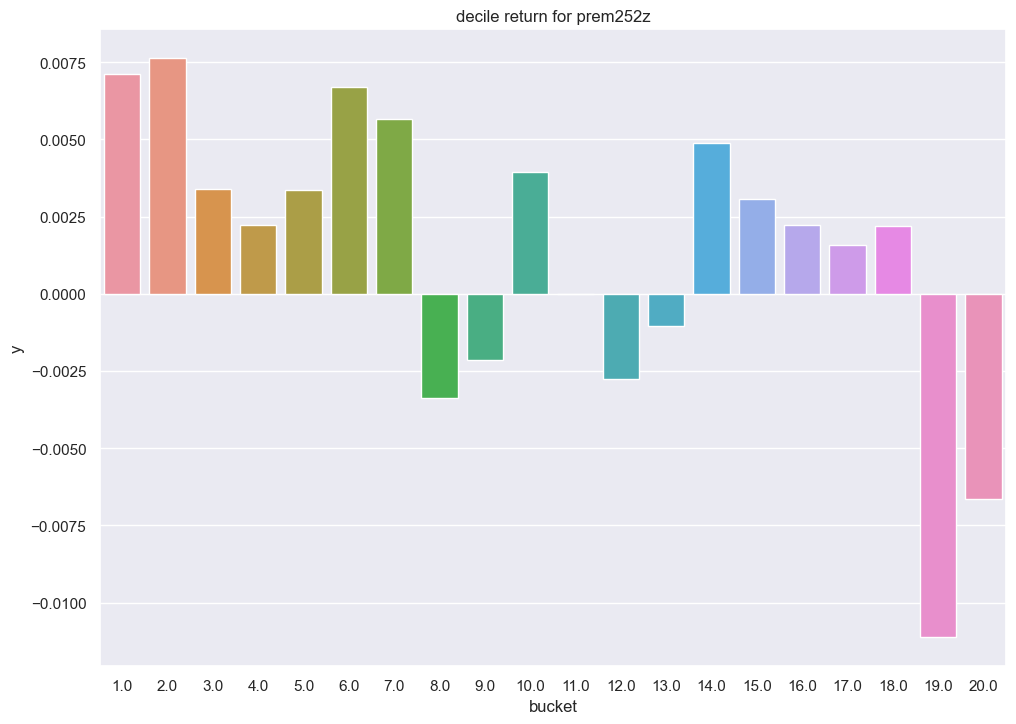

In [4]:
# follow my styles in R, calculate decile ret for each date then average across each date as there could be different # of stocks at each time
data = VIXRB1.copy()
data['Date']=pd.to_datetime(data['Date'])
buckets = 20
ascending = False
data.loc[:, 'bucket'] = data['prem252z'].transform(
        lambda x: pd.qcut(x.rank(method='first', ascending=ascending), q=buckets, labels=False, duplicates="drop")) + 1

    # average return of different groups
factor_ret = data.groupby(['bucket','Date'], as_index=False)['y'].mean()

decile_ret = factor_ret.groupby(['bucket'], as_index=False)['y'].mean()

print(decile_ret)

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your dataset
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=decile_ret.bucket, y=decile_ret['y'])
ax.set_title('decile return for prem252z')
plt.show()
# plt.savefig('decile_plot.png', dpi=300)

In [5]:
# create lags of the X variables  for 1, 2, 3, 4, 5 days
vars = MLdata.columns.tolist()[5:]
print(vars)
lags = [1,2,3,4,5]
lags = [0]
for i in lags:
    for j in vars:
        if i>0:
            MLdata[j+'lag'+str(i)+'diff'] = MLdata[j]-MLdata[j].shift(i)
print(MLdata.columns)

MLdata.to_csv("VIXMLdata0lag.csv")

['mu', 'prem', 'vratio', 'SPYret', 'VIXret', 'XIVret', 'VIX5z', 'mu5z', 'prem5z', 'vratio5z', 'VIX20z', 'mu20z', 'prem20z', 'vratio20z', 'VIX60z', 'mu60z', 'prem60z', 'vratio60z', 'VIX252z', 'mu252z', 'prem252z', 'vratio252z', 'VIX5mu', 'VIX5sd', 'VIX5skew', 'VIX5kurt', 'VIXret5mu', 'VIXret5sd', 'VIXret5skew', 'VIXret5kurt', 'XIVret5mu', 'XIVret5sd', 'XIVret5skew', 'XIVret5kurt', 'mu5mu', 'mu5sd', 'mu5skew', 'mu5kurt', 'prem5mu', 'prem5sd', 'prem5skew', 'prem5kurt', 'vratio5mu', 'vratio5sd', 'vratio5skew', 'vratio5kurt', 'VIX20mu', 'VIX20sd', 'VIX20skew', 'VIX20kurt', 'VIXret20mu', 'VIXret20sd', 'VIXret20skew', 'VIXret20kurt', 'XIVret20mu', 'XIVret20sd', 'XIVret20skew', 'XIVret20kurt', 'mu20mu', 'mu20sd', 'mu20skew', 'mu20kurt', 'prem20mu', 'prem20sd', 'prem20skew', 'prem20kurt', 'vratio20mu', 'vratio20sd', 'vratio20skew', 'vratio20kurt', 'VIX30mu', 'VIX30sd', 'VIX30skew', 'VIX30kurt', 'VIXret30mu', 'VIXret30sd', 'VIXret30skew', 'VIXret30kurt', 'XIVret30mu', 'XIVret30sd', 'XIVret30skew

In [6]:
# a simple Ml trial with catboost use data before 2018 as train and the rest as test, all the columns except y are features

cutoff = '2018-01-01'
train = MLdata[MLdata['Date']<cutoff]
test = MLdata[MLdata['Date']>=cutoff]
# train.drop(['Date'],axis=1,inplace=True)
# test.drop(['Date'],axis=1,inplace=True)
# train.head()
print(train.columns)


Index(['Date', 'VIX', 'SPY', 'y', 'classy', 'mu', 'prem', 'vratio', 'SPYret',
       'VIXret',
       ...
       'mu60skew', 'mu60kurt', 'prem60mu', 'prem60sd', 'prem60skew',
       'prem60kurt', 'vratio60mu', 'vratio60sd', 'vratio60skew',
       'vratio60kurt'],
      dtype='object', length=123)


In [7]:
y_name = 'classy'
x_indexs = np.arange(5,train.shape[1])
x_indexs = np.append(1,x_indexs)
Ytrain = train[y_name].values
Xtrain1 = train.iloc[:, x_indexs]
print(Xtrain1.columns)
Xtrain = Xtrain1.values 

Index(['VIX', 'mu', 'prem', 'vratio', 'SPYret', 'VIXret', 'XIVret', 'VIX5z',
       'mu5z', 'prem5z',
       ...
       'mu60skew', 'mu60kurt', 'prem60mu', 'prem60sd', 'prem60skew',
       'prem60kurt', 'vratio60mu', 'vratio60sd', 'vratio60skew',
       'vratio60kurt'],
      dtype='object', length=119)


In [8]:
# get the correlation matrix of the features with y and plot it
corr = train.iloc[:,3:].corr()
# corr.style.background_gradient(cmap='coolwarm')


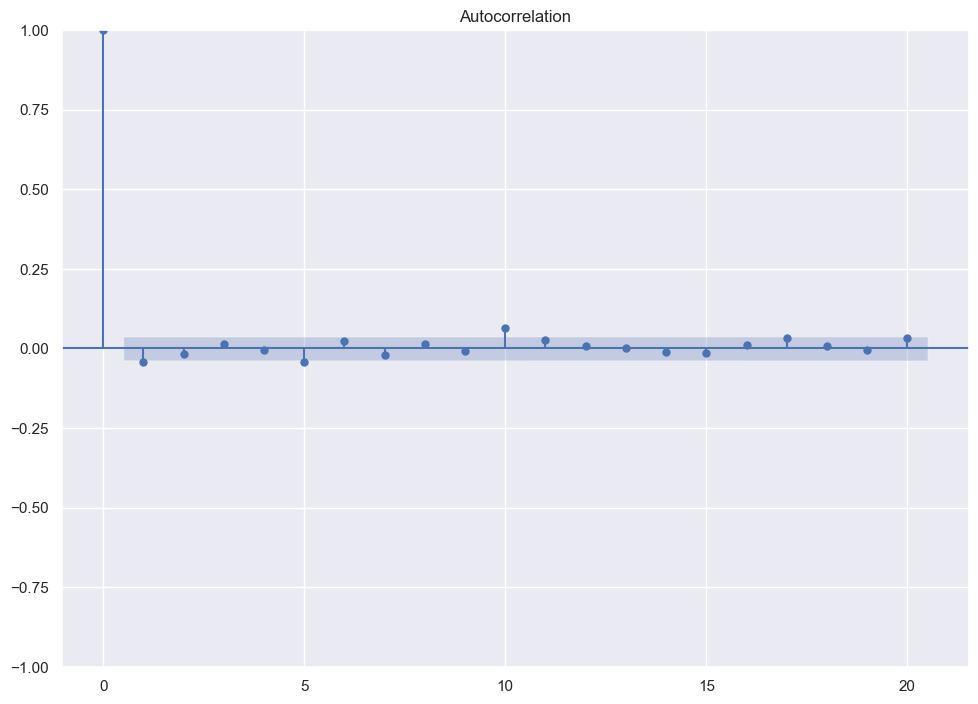

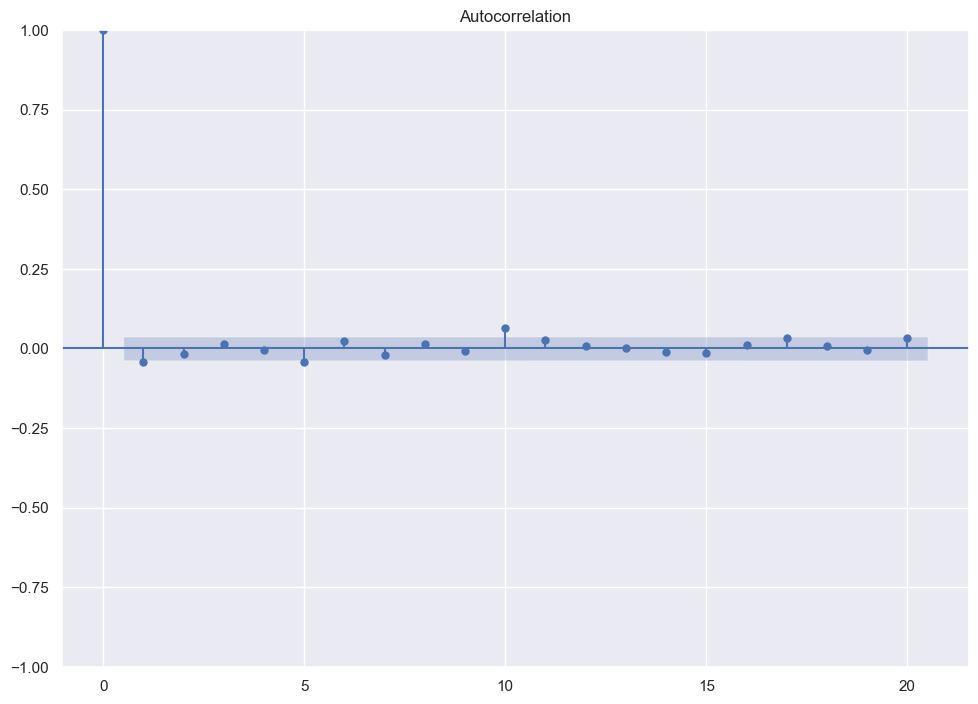

In [9]:

# plot the acf of y
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train['y'], lags=20)


In [10]:
# train the default model
ite = 2000
model = cat.CatBoostRegressor(
    logging_level="Silent",
    iterations=ite,
    task_type='CPU'
)

train_pool = Pool(Xtrain1, Ytrain)
model.fit(train_pool)
# model.save_model(modelname)

# model = cat.CatBoostRegressor()
# model.load_model(modelname)

# go with the test set
# Xtest = test.iloc[:, x_indexs].values
Xtest1 = test.iloc[:, x_indexs]
Ytest = test[y_name].values
test_pool = Pool(Xtest1, Ytest)
Z = model.predict(test_pool)

pred_y = Z
bigtest = test.copy()  # just my naming convention to get the pred_y into the table
bigtest['pred_y'] = pred_y

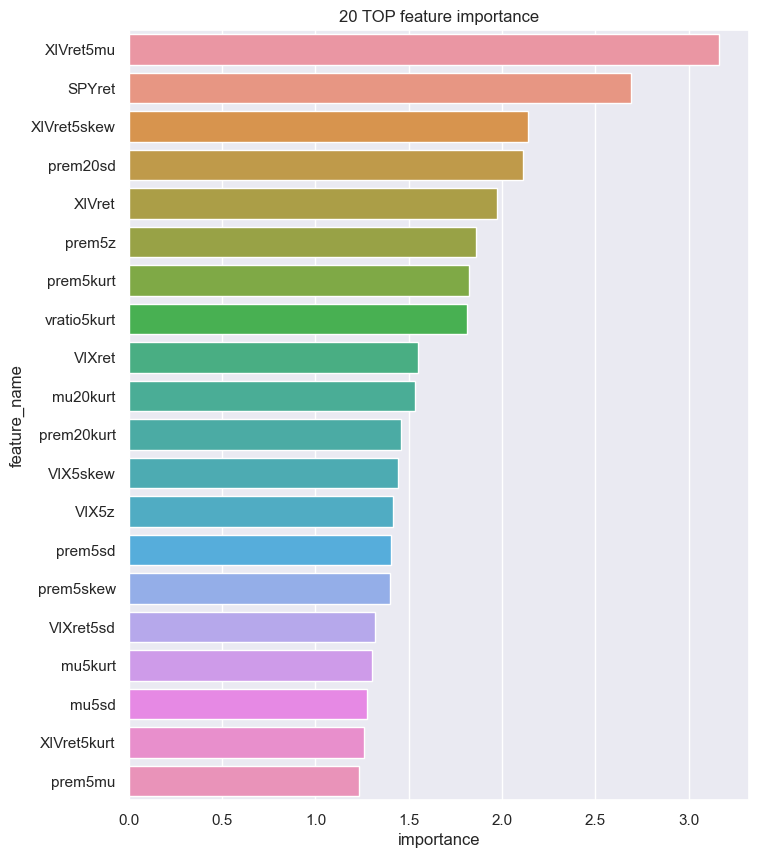

In [11]:
import seaborn as sns
# plot the variable importance
importances = model.get_feature_importance(train_pool) # it is still an np array even if you have the names in the pool
feature_names = Xtrain1.columns
feature_importance = pd.DataFrame(list(zip(feature_names, importances)), columns=['feature_name', 'importance'])
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance = feature_importance.iloc[:20, :]
plt.figure(figsize=(8, 10))
plt.title('20 TOP feature importance')
sns.barplot(x='importance', y='feature_name', data=feature_importance)
plt.show()

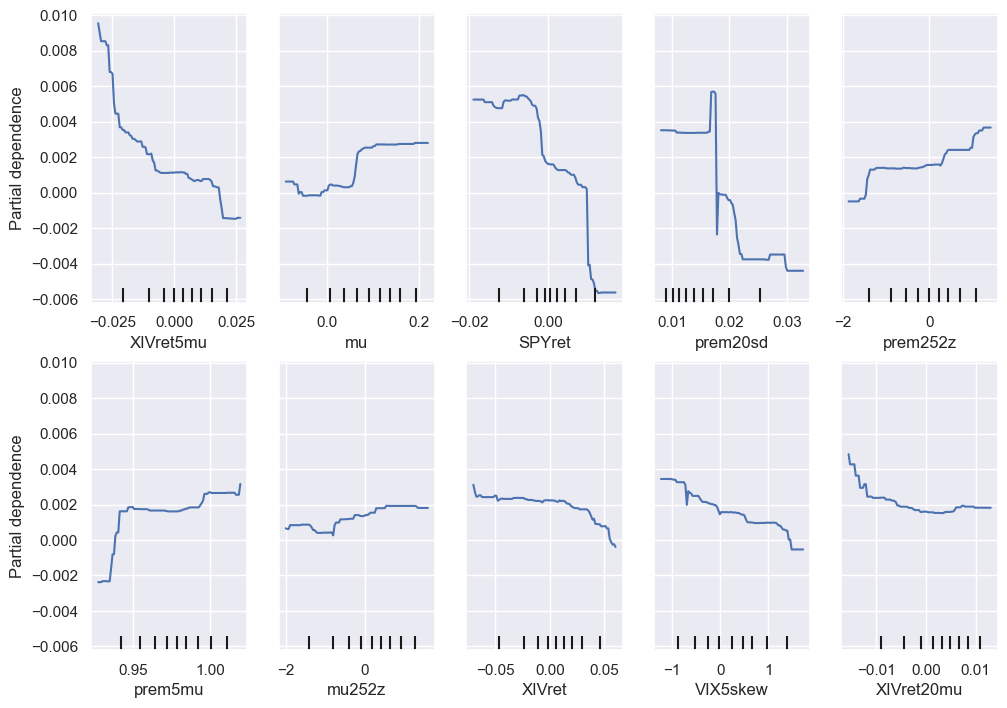

In [12]:
# to use the name in the list we have to use the Xtrain1 df with col names
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# features = [1,2,4]  # Change '0' and '(0, 1)' with the indices or column names of your features
# PartialDependenceDisplay.from_estimator(model, Xtrain, features, kind='average')

features = ["XIVret5mu","mu","SPYret","prem20sd","prem252z","prem5mu","mu252z","XIVret","VIX5skew","XIVret20mu"]  # Change '0' and '(0, 1)' with the indices or column names of your features
# PartialDependenceDisplay.from_estimator(model, Xtrain1, features, kind='average')
PartialDependenceDisplay.from_estimator(model, Xtrain1, features, kind='average',n_cols=5)



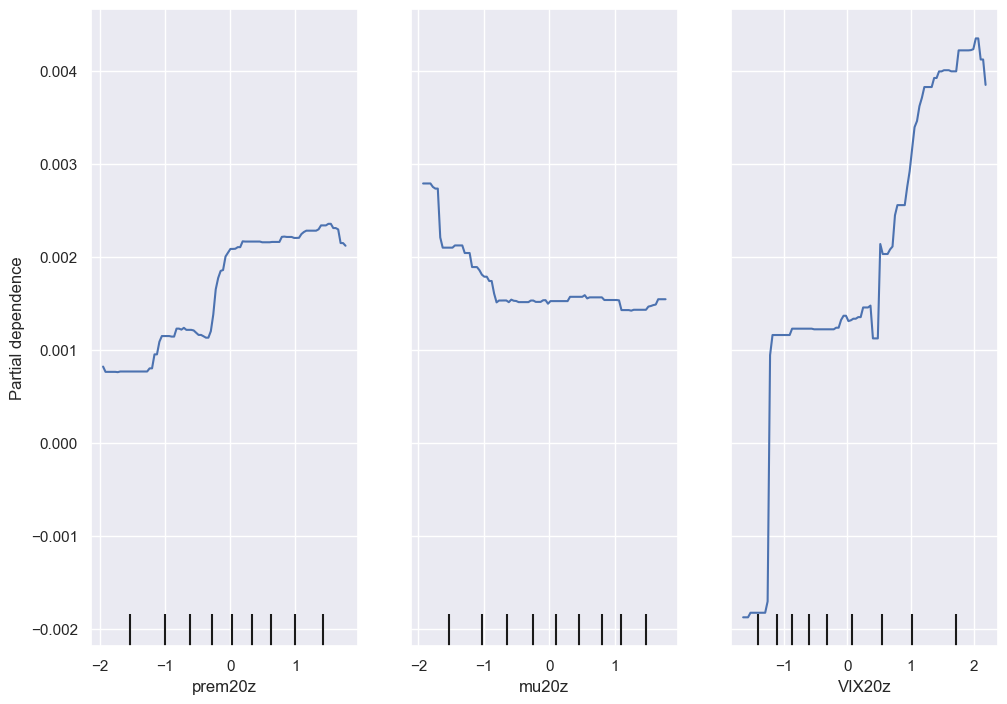

In [13]:
features = ["prem20z","mu20z","VIX20z"]  # Change '0' and '(0, 1)' with the indices or column names of your features
# PartialDependenceDisplay.from_estimator(model, Xtrain1, features, kind='average')
PartialDependenceDisplay.from_estimator(model, Xtrain1, features, kind='average')

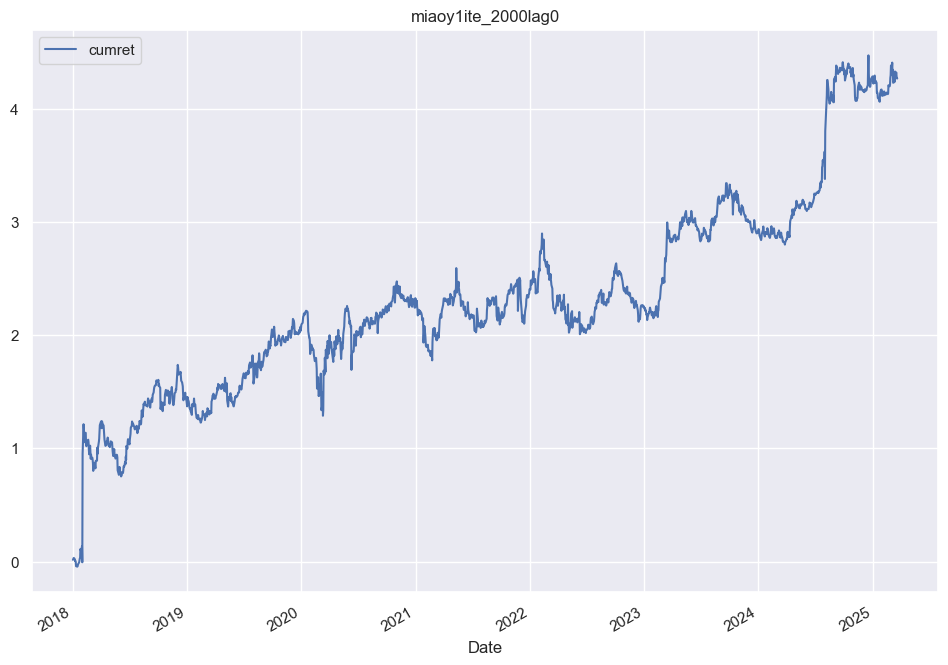

In [14]:
# Algo evaluation
bigtest['pos']=np.sign(bigtest['pred_y'])
bigtest['stratret'] = bigtest['pos']*bigtest['y']
bigtest['cumret'] = bigtest['stratret'].cumsum()
bigtestsmall=bigtest[['Date','y','pred_y','VIX','mu','SPYret','VIXret','XIVret','cumret']]
modelname = 'miao' + 'y' + str(lookahead)+ 'ite_' + str(ite) + 'lag' + str(np.max(lags))
# plot the time series of cumret with the Date column as x axis, change the title to the model name
bigtest.plot(x='Date',y='cumret',title=modelname)
# print(bigtest.cumret.tail())


bigtest.to_csv("miaoVIX.csv")

A special case on 2018-02-05 to long XIV from the model?

In [15]:
bigtest.iloc[23,:]
Xtest1.iloc[23,:]

VIX             37.320000
mu              -0.198353
prem             1.063544
vratio           1.326697
SPYret          -0.041822
                  ...    
prem60kurt      18.114766
vratio60mu       0.834220
vratio60sd       0.082451
vratio60skew     3.893064
vratio60kurt    21.418904
Name: 3051, Length: 119, dtype: float64

In [17]:
import shap

# Get the Shapley values for the CatBoost model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xtest1)

# Plot the Shapley plot for item 100
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[23, :], Xtest1.iloc[23, :])

In [19]:
# random gbm w/o the variable selection, I intentionally use a "worse" iteration number to see if the RF approcah is robust. The results are very satisfying 

ite = 2000
newmodel = cat.CatBoostRegressor(
    logging_level="Silent",
    iterations=ite,
    task_type='CPU'
)
y_name = 'classy'
x_indexs = list(range(5,train.shape[1]))
Ytrains = train[y_name].values
Xtrain1 = train.iloc[:, x_indexs]
# print(Xtrain1.columns)
Xtrains = Xtrain1.values 

Xtest = test.iloc[:, x_indexs].values
Ytest = test[y_name].values
test_pool = Pool(Xtest, Ytest)


from random import sample
obs,ncol = Xtrains.shape

n_boot = 10

df = pd.DataFrame()
for i in range(n_boot):
    print(i)
    samples = np.random.choice(obs, size = obs)
#    samples = list(range(obs))
    Xtrain = Xtrains[samples,:]
    Ytrain = Ytrains[samples]
    
    train_pool = Pool(Xtrain, Ytrain)
    val_pool = Pool(Xtrains, Ytrains)
    newmodel.fit(train_pool,early_stopping_rounds=30,use_best_model=True,eval_set=val_pool)
    Z = newmodel.predict(test_pool)
    best_iteration = newmodel.get_best_iteration()
    print("Best iteration:", best_iteration)

    
    # eval_set  = [(Xtrains,Ytrains)] # this is to follow Brieman's 1996 paper using the population as test set
    # clf = xgb.XGBRegressor(n_estimators=4000,verbose = 0,
    #                        tree_method='gpu_hist', early_stopping_rounds=30)

    # clf.fit(Xtrain,Ytrain, eval_set=eval_set)
    
    # Z = clf.predict(Xtest)
    pred_y = Z
    name = str(i)
    df[name]=pred_y

bigtest = test.copy().reset_index()  # use the original test to include all the other columns
bigtest['pred_y'] = df.mean(axis=1,skipna=True)

0
Best iteration: 1997
1
Best iteration: 1999
2
Best iteration: 1999
3
Best iteration: 1999
4
Best iteration: 1995
5
Best iteration: 1999
6
Best iteration: 1999
7
Best iteration: 1999
8
Best iteration: 1999
9
Best iteration: 1999


The bagging was even worse than the baseline but still usable

<AxesSubplot:title={'center':'miaoy1ite_2000lag0 RF'}, xlabel='Date'>

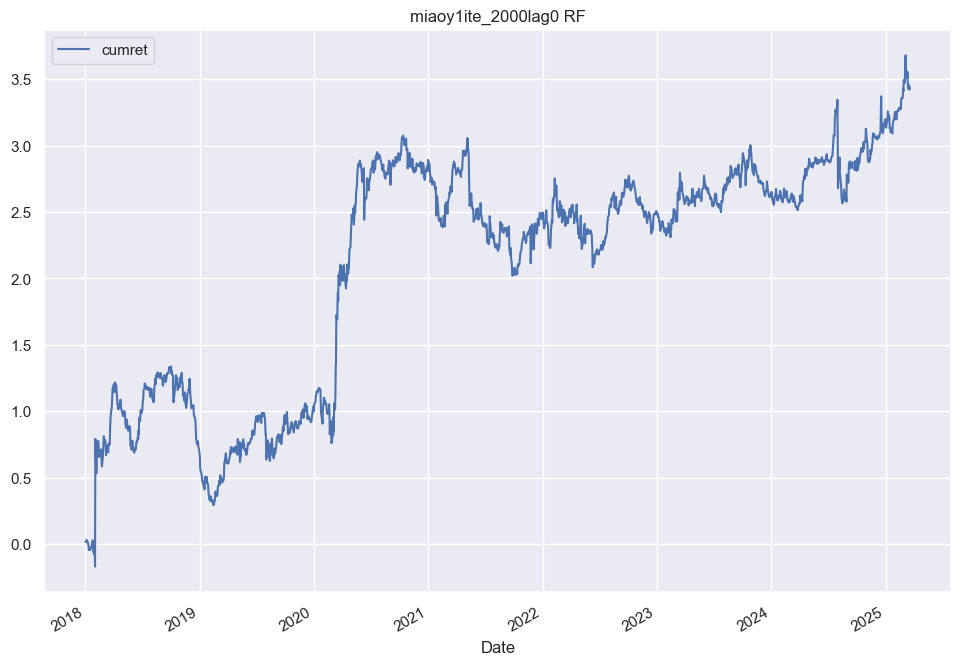

In [20]:
# Algo evaluation
bigtest['pos']=np.sign(bigtest['pred_y'])
bigtest['stratret'] = bigtest['pos']*bigtest['y']
bigtest['cumret'] = bigtest['stratret'].cumsum()
bigtestsmall=bigtest[['Date','y','pred_y','VIX','mu','SPYret','VIXret','XIVret','cumret']]
modelname = 'miao' + 'y' + str(lookahead)+ 'ite_' + str(ite) + 'lag' + str(np.max(lags)) + ' RF'
# plot the time series of cumret with the Date column as x axis, change the title to the model name
bigtest.plot(x='Date',y='cumret',title=modelname)
# print(bigtest.cumret.tail())

I will go with optuna to tune the lgm. Copied from my CN stock trading setup

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import optuna
from sklearn.utils import resample
from lightgbm import LGBMRegressor

#%% split based on date
days = np.unique(train.Date)
sample_size = int(round(np.size(days))*0.8)
t_days= np.random.choice(days, replace=False, size=sample_size)

Train = train[train.Date.isin(t_days)]
Test = train[~train.Date.isin(t_days)]

train_y = Train[y_name].values
train_x = Train.iloc[:,x_indexs].values
test_y = Test[y_name].values
test_x = Test.iloc[:,x_indexs].values

In [ ]:

#%% optuna lgm


# GPU is very easy to fail on memory
def objective(trial):
    
    
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,40,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'min_data_per_group' : trial.suggest_int('min_data_per_group', 1, 100),
        'device' : 'gpu',
        'early_stopping_rounds' :100,
        'verbose' : -1
        # 'extra_trees' : True
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)])
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

#%% train xgb
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

import pickle 

object_pi = study.best_trial.params
filename = 'VIX' + '.sav'
# pickle.dump(object_pi, open(filename,'wb'))



In [ ]:
params=object_pi 
params['random_state'] = 48
params['n_estimators'] = 20000
params['metric'] = 'rmse'
params['verbosity'] = -1
# params['cat_smooth'] = params.pop('min_data_per_groups')


model = LGBMRegressor(**params)
model.fit(Xtrain,Ytrain,eval_set=[(Xtrain,Ytrain)])


In [ ]:
#%% go with the test set
Xtest = test.iloc[:,x_indexs].values
Ytest = test[y_name].values
 
Z = model.predict(Xtest)

pred_y = Z
bigtest = test.copy() # just my naming convention to get the pred_y into the table
bigtest['pred_y'] = pred_y



In [ ]:
# Algo evaluation
bigtest['pos']=np.sign(bigtest['pred_y'])
bigtest['stratret'] = bigtest['pos']*bigtest['y']
bigtest['cumret'] = bigtest['stratret'].cumsum()
bigtestsmall=bigtest[['Date','y','pred_y','VIX','mu','SPYret','VIXret','XIVret','cumret']]
modelname = 'lgm' + 'y' + str(lookahead)+ 'ite_' + str(ite) + 'lag' + str(np.max(lags))
# plot the time series of cumret with the Date column as x axis, change the title to the model name
bigtest.plot(x='Date',y='cumret',title=modelname)
# print(bigtest.cumret.tail())